In [1]:
import torch
import torch.nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [7]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [8]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

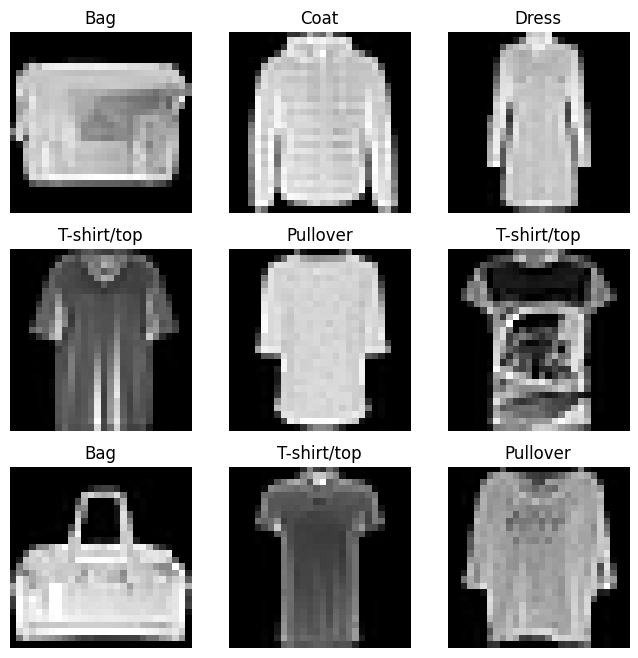

In [9]:
classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

In [37]:
class ClassificationImageModel(torch.nn.Module):

    def __init__(self):
        super(ClassificationImageModel, self).__init__()
            
        self.conv1 = torch.nn.Conv2d(1, 3, 3)
        self.conv2 = torch.nn.Conv2d(3, 6, 3)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.relu = torch.nn.ReLU()
        self.linear1 = torch.nn.Linear(5 * 5 * 6, 128)
        self.linear2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [39]:
model = ClassificationImageModel().to(device)

In [40]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [42]:
for epoch in range(10):
    running_loss = 0.0
    for image, label in train_loader:
        image, label = image.to(device), label.to(device)

        outputs = model(image) # [batch_size, 10], содержит outputs.grad_fn
        loss = criterion(outputs, label) # [1,], скопировал outputs.grad_fn
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Эпоха {epoch}, Потери: {running_loss}")


Эпоха 0, Потери: 1294.0350321144797
Эпоха 1, Потери: 1270.807919442188
Эпоха 2, Потери: 1249.0059484615922
Эпоха 3, Потери: 1226.9658050667495
Эпоха 4, Потери: 1208.1438221959397
Эпоха 5, Потери: 1191.4267593971454
Эпоха 6, Потери: 1176.982374444604
Эпоха 7, Потери: 1157.4437823989429
Эпоха 8, Потери: 1144.6441489206627
Эпоха 9, Потери: 1129.0057747019455


In [58]:
PATH = './model.pth'
torch.save(model.state_dict(), PATH)

In [59]:
model = ClassificationImageModel()
model.load_state_dict(torch.load(PATH, weights_only=False))

<All keys matched successfully>

In [67]:
model.to(device)
model.eval()

ClassificationImageModel(
  (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear1): Linear(in_features=150, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
)

In [61]:
test_images, test_labels = next(iter(test_loader))

outputs = model(test_images)
_, predicted = torch.max(outputs, 1)

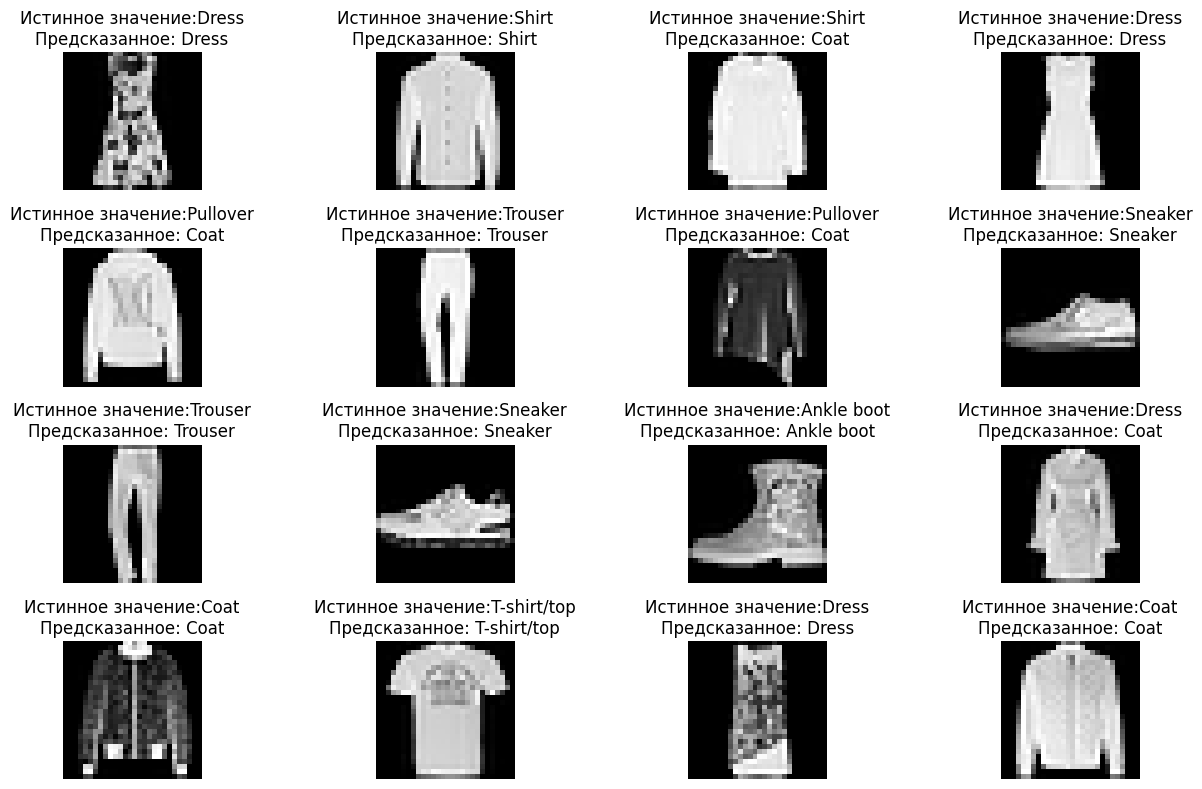

In [62]:
figure = plt.figure(figsize=(16, 8))
rows, cols = 4, 4
for i, image_label in enumerate(zip(test_images, test_labels)):
    figure.add_subplot(rows, cols, i+1)
    plt.imshow(image_label[0].squeeze(), cmap='gray')
    plt.title(f'Истинное значение:{classes[image_label[1]]}\nПредсказанное: {classes[predicted[i]]}')
    plt.axis('off')
    plt.tight_layout()

In [63]:
total = 0
correct = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total} %")

Accuracy: 86.8 %


In [81]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("runs/demo")

global_step = 0
for epoch in range(2):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        # grad norm
        total_grad_norm = 0.0
        for p in model.parameters():
            if p.grad is not None:
                total_grad_norm += p.grad.detach().norm().item()**2
        total_grad_norm = total_grad_norm**0.5

        # weight norm
        total_weight_norm = 0.0
        for p in model.parameters():
            total_weight_norm += p.detach().norm().item()**2
        total_weight_norm = total_weight_norm**0.5

        writer.add_scalar("loss", loss.item(), global_step)
        writer.add_scalar("grad_norm", total_grad_norm, global_step)
        writer.add_scalar("weight_norm", total_weight_norm, global_step)

        optimizer.step()
        global_step += 1
